In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import random
from torch.nn.utils.rnn import pad_sequence
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import re
from nltk.corpus import stopwords
import nltk
import gensim
nltk.download('stopwords')
google_path = "drive/My Drive/News/GoogleNews-vectors-negative300.bin"
import matplotlib.pyplot as plt
import torch.nn.functional as F

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# We will be using the google word2vec for getting pre trained embeddings 
word2vec = gensim.models.KeyedVectors.load_word2vec_format(google_path, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# The task here is to summarize reviews from amazone
data_path =  "drive/My Drive/test_summary/Reviews.csv"

In [0]:
# Reading data
df = pd.read_csv(data_path)

In [6]:
# Lets see how it looks like !!!
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
# We only need the text and Summary
df= df[["Text" , "Summary"]]
df = df.dropna()

In [0]:
# We use the following mapping to convert short hand notations
# Credits Kaggle
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [0]:
# Borrowing this preprocessing function from kaggle and making some modifications

stop_words = stopwords.words('english')

def preprocess(text):
    text = text.lower() # lowercase
    text = text.split() # convert have'nt -> have not
    for i in range(len(text)):
        word = text[i]
        if word in contraction_mapping:
            text[i] = contraction_mapping[word]
    newtext = []
    for word in text:
        if word not in stop_words and "href" not in word and "http" not in word:
            newtext.append(word)
    text = " ".join(newtext)
    text = text.replace("'s",'') # convert your's -> your
    text = re.sub(r'\(.*\)','',text) # remove (words)
    text = re.sub(r'[^a-zA-Z ]','',text) # remove punctuations
    text = re.sub(' +', ' ', text) # Remove extra spaces
    text = re.sub(r'\"','',text)
    newtxt = []
    for w in text.split(" "):
        if(w not in word2vec):
            newtxt = newtxt + word_cleaner(w)
        else:
            newtxt.append(w)
    return " ".join(newtxt)


# The word cleaner function does the following 
# diningroom --> dining room
# This is done so that maximum words are recognized in google word2vec

def word_cleaner(w):
    L = len(w)
    arr = []
    i = L
    while(i > 0):
        if(w[0:i] in word2vec):
            arr.append(w[0:i])
            break
        i = i -1
    if(w[i:] in word2vec):
        arr.append(w[i:])
    return arr


In [0]:
# Applying preprocessing
df["Text"] = df["Text"].apply(lambda x:preprocess(x))
df["Summary"] = df["Summary"].apply(lambda x: preprocess(x))

In [11]:
# We have a total of 500 thousand Text summary pairs
len(df)

568427

In [0]:
# Deleting Text smaller than 10 words 
max_summary_length = 10
def func_text(s):
    if(len(s.split(" ")) <= 10 or len(s.split(" ")) > 50):
        return False
    return True

# Deleting summary greater than 10
def func_summary(s):
    if(len(s.split(" ")) > max_summary_length):
        return False
    return True


# The cut-off were decided after poltting histograms for both text length and summary length
df =  df[df["Text"].apply(lambda x:func_text(x))]
df =  df[df["Summary"].apply(lambda x:func_summary(x))]


In [0]:
arr = []
for s in df["Text"]:
    arr.append(len(s.split(" ")))
brr = []

for s in df["Summary"]:
    brr.append(len(s.split(" ")))
        

(array([59343., 65520., 56045., 47462., 41311., 35137., 30338., 26147.,
        22870., 19759.]),
 array([11. , 14.9, 18.8, 22.7, 26.6, 30.5, 34.4, 38.3, 42.2, 46.1, 50. ]),
 <a list of 10 Patch objects>)

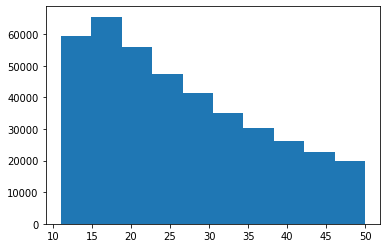

In [14]:
plt.hist(arr)
# Ploting the sentence length histogram for Text

(array([ 67271., 132501.,  90208.,  58968.,  28633.,  14369.,   7175.,
          2896.,   1356.,    555.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

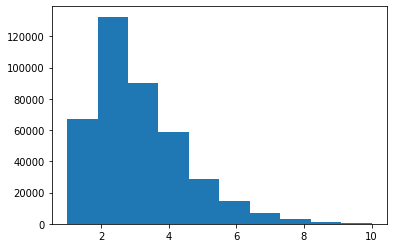

In [15]:
plt.hist(brr)
# Ploting the sentence length histogram for Summary

In [0]:
# after all the preprocessing we are left with around 400 thousand training examples 

In [18]:
# Lets look at a training example
print(df["Text"][1154])
print(df["Summary"][1154])

ordered three trays found two old stale admit checking outof date exterior package still dried fruit last tray fresher experience soured point i am disappointed
mostly dry


In [0]:
# Now lets start making dicts for word to index and viceversa
def dict_maker(data):
    word2index = {}
    index2word = {}
    word2index["<pad>"] = 0
    word2index["<bos>"] = 1
    word2index["<eos>"] = 2
    index2word[0] = "<pad>"
    index2word[1] = "<bos>"
    index2word[2] = "<eos>"
    index = 3
    text = data["Text"].values
    summary = data["Summary"].values

    for txt,summ in zip(text,summary):
        for word in txt.split(" "):
            if(word not in word2index):
                word2index[word] = index
                index2word[index] = word
                index += 1
        for word in summ.split(" "):
            if(word not in word2index):
                word2index[word] = index
                index2word[index] = word
                index += 1
    return word2index , index2word
        




In [0]:
word2index , index2word = dict_maker(df)

In [21]:
# lets make and store embedding vectors, so that we no longer have to keep 
# The google word2vec in RAM memory
embedding = torch.empty(len(word2index) + 3 , 300)
# This embedding will not be a trainable parameter
for i in range(len(word2index)):
    w = index2word[i]
    if(w not in word2vec):
        embedding[i] = torch.rand(300)
        print(w)
    else:
        embedding[i] = torch.tensor(word2vec[index2word[i]])

# As expected the only words not present in word2vec are .....

<pad>
<bos>
<eos>



In [0]:
# Time to say goodbye to google word2vec and free up some RAM
del word2vec

In [0]:
# Now lets convert out data to numbers
def add_bos_eos(s):
    return "<bos> " + s + " <eos>"
def convert_words_to_numbers(s):
    arr = []
    for w in s.split(" "):
        arr.append(word2index[w])
    return arr

df["Summary"] = df["Summary"].apply(lambda x: add_bos_eos(x))
df["Text"] = df["Text"].apply(lambda x: convert_words_to_numbers(x))
df["Summary"] = df["Summary"].apply(lambda x: convert_words_to_numbers(x)) 
max_summary_length += 2

In [0]:
df = df.values

In [0]:
index = np.random.randint(low = 0 ,high = len(df) , size = (50000))


In [0]:
#total = len(df)
# Now I did not have enough time to train the entire data so.... I only train on random 50000 points
#train_size = int(.8*total)
index_train = np.random.randint(low = 0 ,high = len(df) , size = (50000))
train_data = df[index]


In [0]:
test_data = df[:10000]

In [0]:
# Now lets make a batch feeder function
def get_train_batch(data , batch_size , max_summary_size):
    index = np.random.randint(low = 0 , high = len(data) -1 , size = batch_size)
    batch = data[index]
    X_batch = batch[:,0].tolist()
    y_batch = batch[:,1].tolist()
    # We have a random sample of size "batch_size"

    X_batch = list(map(lambda x: torch.tensor(x) , X_batch)) # Converting each batch into tensors
    y_batch = list(map(lambda x: torch.tensor(x) , y_batch))

    X = pad_sequence(X_batch , batch_first= True) # We now pad the shorter sequences with zeros
    y = pad_sequence(y_batch , batch_first= True) 
    y = torch.cat((y,torch.zeros(batch_size, max_summary_size - y.size(1)).long()) , dim = 1)

    
    return X.to(dtype=torch.long, device=device),y.to(dtype=torch.long, device=device)


***Onto the model***

In [0]:
class summarizer(nn.Module):
    def __init__(self , embeddings , LSTM_input_dim ,LSTM_hidden_dim , max_summary_size):
        super().__init__()
        self.embedding = nn.Embedding(len(word2index) , 300)
        self.embedding.weight = nn.Parameter(embedding)
        # Remember we do not wnat to train the embeddings, so we will set its requires grad flag s False
        self.embedding.weight.requires_grad = False
        self.max_summary_size = max_summary_size
      

        self.LSTM_hidden_dim = LSTM_hidden_dim
        self.LSTM_input_dim = LSTM_input_dim

        self.linear1 = nn.Linear(300 ,self.LSTM_input_dim)
        self.Encoder_LSTM = nn.LSTM(input_size= self.LSTM_input_dim , hidden_size=self.LSTM_hidden_dim , batch_first = True)

        self.attention_layer = nn.Linear(self.LSTM_hidden_dim  , self.LSTM_hidden_dim)
        self.Decoder_LSTM = nn.LSTM(input_size = self.LSTM_hidden_dim , hidden_size= self.LSTM_hidden_dim, batch_first= True)

        self.context_to_LSTM = nn.Linear(self.LSTM_hidden_dim , self.LSTM_hidden_dim - 300)

        self.Decoder_to_final = nn.Linear(self.LSTM_hidden_dim , len(word2index))

    def calculate_attention(self, prev_out , encoder_out):
        # Here lets calculate the attention energies
        seq_len = encoder_out.size(1)
        X = self.attention_layer(encoder_out)
        X = X.transpose(1,2)
        att_energy = torch.bmm(prev_out , X)
        att_energy =  F.softmax(att_energy , dim = 2)
        return att_energy   # Now it has the shape (batch_size , 1,seq_len)

    def decoder_teacher(self ,encoder_out , target_embedding ):
        # We decode by forcing the model the correct sequence
        # This helps in convergence,but is clearly not how the model works !!!!
        batch_size , seq_len , _ = encoder_out.size()
        # Initially the previous decoder output is all zeros
        prev_out = torch.zeros(batch_size , 1 , self.LSTM_hidden_dim).to(device).double()

        # Lets make a tensor to store the final result
        final_out = torch.zeros( batch_size, self.max_summary_size, self.LSTM_hidden_dim).to(device).double()

        # Initilizing the decoder state vector (with zeros)
        decoder_state = (torch.zeros(1, batch_size ,self.LSTM_hidden_dim).to(device).double(),torch.zeros(1, batch_size ,self.LSTM_hidden_dim).to(device).double())


        # Next the loop fills the final tensor in sequence order
       
        for i in range(self.max_summary_size):
            # Calculating attention energies
            attention_energy = self.calculate_attention(prev_out , encoder_out)
            
            context = torch.bmm(attention_energy , encoder_out)
            context = self.context_to_LSTM(context)
            decoder_LSTM_inp = torch.cat((target_embedding[: , i:i+1 , :] , context ), dim = 2)
            decoder_out , decoder_state = self.Decoder_LSTM(decoder_LSTM_inp , decoder_state)
            final_out[: , i:i+1 , :] = decoder_out
            prev_out = decoder_out
        return final_out
    
    def decoder_non_teacher(self , encoder_out , word_embedding):
        # here the model takes as input its own generated words
        # This is exactely inference is made with this model
        batch_size , seq_len , _ = encoder_out.size()
        prev_out = torch.zeros(batch_size , 1 , self.LSTM_hidden_dim).to(device).double()
        final_out = torch.zeros(batch_size , self.max_summary_size, self.LSTM_hidden_dim).to(device).double()
        # Initilizing the decoder state vector (with zeros)
        decoder_state = (torch.zeros(1, batch_size ,self.LSTM_hidden_dim).to(device).double(),torch.zeros(1, batch_size ,self.LSTM_hidden_dim).to(device).double())       
       
       
        for i in range(self.max_summary_size):
            attention_energy = self.calculate_attention(prev_out , encoder_out)
            context = torch.bmm(attention_energy , encoder_out)
            context = self.context_to_LSTM(context)
            decoder_LSTM_inp = torch.cat((word_embedding , context ), dim = 2)
            decoder_out , decoder_state = self.Decoder_LSTM(decoder_LSTM_inp , decoder_state)
            final_out[: , i:i+1 , :] = decoder_out
            prev_out = decoder_out
            with torch.no_grad():
                # Now using the model's prediction to feed its next step
                decoder_out  = self.Decoder_to_final(decoder_out)
                word_index = torch.argmax(decoder_out , dim = 2)                  
                word_embedding = self.embedding(word_index)
        return final_out

    def forward(self , Text , Summary , teacher = True):
        text_embedding = self.embedding(Text)
        summary_embedding = self.embedding(Summary)

        X = self.linear1(text_embedding)

        #Encoding
        encoder_out  , _ = self.Encoder_LSTM(X)

        if(teacher):
            final_out = self.decoder_teacher(encoder_out , summary_embedding)
        else:
            final_out = self.decoder_non_teacher(encoder_out , summary_embedding[:,0,:].unsqueeze(1))
        distribution = self.Decoder_to_final(final_out)
        return distribution

    def Infer(self ,X):
        # Here we use the non teacher decoder to get feed the model its own output
        with torch.no_grad():
            X = self.embedding(X)
            X = self.linear1(X)
            encoder_out ,_ = self.Encoder_LSTM(X)
            embedding_index = torch.ones(X.size(0) ,1).to(device).long()
            final_out = self.decoder_non_teacher(encoder_out, self.embedding(embedding_index))
            final_out = self.Decoder_to_final(final_out)
            final_out = torch.argmax(final_out , dim = -1)
        return final_out




In [0]:
model = summarizer(embeddings = embedding ,LSTM_input_dim=500 , LSTM_hidden_dim= 1000 , max_summary_size= max_summary_length ).double().to(device)

In [0]:
learning_rate = .0001
# Removing the embedding from trainable parameters
params_model = list(filter(lambda p: p.requires_grad, model.parameters()))
optimizer = torch.optim.Adam(params_model, learning_rate)
# We use cross entropy loss to train the model
crit = torch.nn.CrossEntropyLoss()

In [0]:
# Now lets train this beast !!!
def loss_func(model_out , labels):
    model_out = model_out.view(-1 , model_out.size(-1))
    labels = labels.view(-1)
    return crit(model_out , labels).mean()

def train(model ,epochs, batch_size):
    inner_loop_iters = len(train_data)//batch_size

    for i in range(epochs):
        epoch_loss = 0
        for _ in range(inner_loop_iters):
            X,y = get_train_batch(train_data,batch_size, max_summary_length)

            # Here we toss a coin !!!!
            # Heads we train with the teacher method
            # Tails we trian wth the non teacher method
            toss = random.random()
            if(toss <= .5):
                output = model.forward(X,y, True)
            else:
                output = model.forward(X,y,False)
            loss = loss_func(output , y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss += loss.item()
        print(epoch_loss/inner_loop_iters)


In [50]:
train(model ,20 , batch_size= 50)

0.8938231541926253
0.8814939409819766
0.8426032427838239
0.8435771515386153
0.8078112826369664
0.803902057640869
0.7947947889309731
0.7789755336877264
0.7244385859911185
0.7285105175049819


In [0]:
# Now lets put this model to test 
def decode_sentence(array):
    arr = []
    for i in array:
        arr.append(index2word[i])
    return arr

def remove_tags(arr):
    arr = arr[1:]
    new_arr = []
    for w in arr:
        if(w == "<eos>"):
            break
        new_arr.append(w)
    return new_arr

def summarize(model, text):
    inp = torch.tensor(text).to(device).unsqueeze(0)
    with torch.no_grad():
        summary = model.Infer(inp)
    summary = summary[0].to("cpu").numpy()
    text = decode_sentence(text)
    summ = decode_sentence(summary)
    text = remove_tags(text)
    summ = remove_tags(summ)

   
    print("TEXT-----> " , " ".join(text))
    print("SUMMARY--> "," ".join(summ ))





In [118]:
summarize(model ,test_data[8545][0])

TEXT----->  daughter turning wanted bubble gum theme course daughter remembered growing well tiny size chiclet s looked everywhere found amazon thrilled purchased several packs introduce year old bring back wonderful memories chiclet s gum still wonderful product always was
SUMMARY-->  great gift


In [121]:
summarize(model ,test_data[8587][0])

TEXT----->  fit perfectly real space saver right size holds coffee choices
SUMMARY-->  great


In [125]:
summarize(model ,test_data[7895][0])

TEXT----->  sweet treat nutritional value fantastic thing find local store lower cost
SUMMARY-->  tasty


In [126]:
summarize(model ,train_data[8545][0])

TEXT----->  recommend new horn hard art coffee we liberty roast we delighted discover lasting flavor also makes flavorful cappuccino espresso pleased enjoying traditional american coffee brand looking forward future coffee roasts hh coffee
SUMMARY-->  great coffee


So yeah it works :) !!!